In [18]:
import pandas as pd
import numpy as np
import time
%matplotlib inline 
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
import time
import re

In [19]:
df_eurovoc = pd.read_excel("data/DOC_1/eurovoc_export_en.xlsx")
df_eurovoc.rename(columns = { "TERMS (PT-NPT)" : "ev"}, inplace = True)

In [3]:
df_eurovoc[["mID", "mev"]] = df_eurovoc["MT"].str.partition().iloc[:, [0,2]]
df_eurovoc.drop(columns = "MT", inplace = True)
df_eurovoc["mID"] = df_eurovoc["mID"].astype("int")
df_eurovoc.head()

ID              ev RELATIONS                  PT   mID  \
0  c_715c08c0     3D printing       NaN                 NaN  3236   
1  c_715c08c0             3DP       USE         3D printing  3236   
2      434966              AA       USE  emission allowance  5206   
3         594  AAMS countries       NaN                 NaN  7231   
4        2894             AAR       USE     activity report  3221   

                                          mev  
0  information technology and data processing  
1  information technology and data processing  
2                        environmental policy  
3                          economic geography  
4                               documentation

In [4]:
#df_eurovoc.query("(MT == 'sources and branches of the law') and terms == 'legal science'")
df_eurovoc.query("(mev == 'political framework')")

ID                          ev RELATIONS                    PT  \
434          1579                  Bundesland       USE      Federation State   
724            32                   Communism       NaN                   NaN   
832          6881     Confederation of States       USE      confederal State   
1546          905               Eurocommunism       NaN                   NaN   
1931          907                   Euroright       NaN                   NaN   
1972          971                     Fascism       NaN                   NaN   
1983         1579            Federation State       NaN                   NaN   
2466         5624               Islamic State       NaN                   NaN   
2634         1579              Land (Germany)       USE      Federation State   
2671         1614                  Liberalism       NaN                   NaN   
2772         1785                      Maoism       NaN                   NaN   
2785         1823                     Marxism       NaN                   NaN   
2866   c_3a2df4eb             Muslim politics       USE       political Islam   
2887         2030          National Socialism       NaN                   NaN   
2895         2030                      Nazism       USE    National Socialism   
3716         1479     Socialist International       NaN                   NaN   
3814          883                       State       NaN                   NaN   
3834         1579       State of a Federation       USE      Federation State   
4263         1967                Universalism       NaN                   NaN   
4368          887               Welfare State       NaN                   NaN   
4405         1478       Workers International       NaN                   NaN   
4470         1977           absolute monarchy       USE             monocracy   
4668         3046              advisory power       NaN                   NaN   
4953         1829                   anarchism       NaN                   NaN   
5261         3002        authoritarian regime       NaN                   NaN   
5267         1977                   autocracy       USE             monocracy   
5950         5626           centralised State       USE       unitarian State   
5999         5483  change of political system       NaN                   NaN   
6020         2033                  chauvinism       USE           nationalism   
6416       435136                 communalism       NaN                   NaN   
...           ...                         ...       ...                   ...   
13399        5805   president of the republic       USE         head of State   
13401        7386         presidential régime       NaN                   NaN   
13742        6884                    protocol       NaN                   NaN   
13781        2588          public authorities       NaN                   NaN   
14067        1174            rebel government       NaN                   NaN   
14170        6882              regional State       NaN                   NaN   
14223        3096                 regionalism       NaN                   NaN   
14383        8424    representative democracy       NaN                   NaN   
14397        3413                    republic       NaN                   NaN   
14523        1174    revolutionary government       USE      rebel government   
14539        2578         right of initiative       USE   power of initiative   
14546        5114               right of veto       USE                  veto   
14653        5875                    royalism       NaN                   NaN   
14660        5622                 rule of law       NaN                   NaN   
14890        5625               secular State       NaN                   NaN   
14892        6862                  secularity       NaN                   NaN   
14967        4093        separation of powers       NaN                   NaN   
15137        2263                single party 

In [5]:
df_mm_m = pd.read_excel("output/df_mm_m.xlsx")
df_mm_m.head()

mmev                             mev  mmID  mID
0  POLITICS             political framework     4  406
1  POLITICS                 political party     4  411
2  POLITICS  electoral procedure and voting     4  416
3  POLITICS                      parliament     4  421
4  POLITICS       parliamentary proceedings     4  426

In [6]:
df_eurovoc = df_eurovoc.merge(df_mm_m)
df_eurovoc.head()

ID                ev RELATIONS                        PT   mID  \
0  c_715c08c0       3D printing       NaN                       NaN  3236   
1  c_715c08c0               3DP       USE               3D printing  3236   
2  c_433922a6               ASP       USE           cloud computing  3236   
3        5520               CAD       USE  computer assisted design  3236   
4        5705  CD-ROM read head       USE                disc drive  3236   

                                          mev                          mmev  \
0  information technology and data processing  EDUCATION AND COMMUNICATIONS   
1  information technology and data processing  EDUCATION AND COMMUNICATIONS   
2  information technology and data processing  EDUCATION AND COMMUNICATIONS   
3  information technology and data processing  EDUCATION AND COMMUNICATIONS   
4  information technology and data processing  EDUCATION AND COMMUNICATIONS   

   mmID  
0    32  
1    32  
2    32  
3    32  
4    32

In [7]:
print(len(df_eurovoc["ID"].drop_duplicates().values))
print(len(df_eurovoc.query("RELATIONS != RELATIONS")["ID"].drop_duplicates()))
#df_eurovoc.query("RELATIONS != RELATIONS").drop_duplicates()

7124
7124


['ID', 'ev', 'mID', 'mev', 'mmID', 'mmev']

In [43]:
df_eurovoc_count = pd.DataFrame(columns = ["ID", "ev", "mID", "mev", "mmID", "mmev", "count"])
starttime = time.time()
for i, key in enumerate(df_eurovoc["ID"].drop_duplicates()):
    if i % 100 == 0:
        print(i)
    sparql = SPARQLWrapper("http://publications.europa.eu/webapi/rdf/sparql")
    sparql.setQuery("""
prefix cdm: <http://publications.europa.eu/ontology/cdm#> 
select distinct?work
where
{
?work cdm:resource_legal_in-force "true"^^<http://www.w3.org/2001/XMLSchema#boolean> ;
a cdm:legislation_secondary;
cdm:work_is_about_concept_eurovoc <http://eurovoc.europa.eu/%s> .
}
    """ % key)
    sparql.setReturnFormat(JSON)
    querydone = False
    while not querydone:
        try:
            results = sparql.query().convert()
            querydone = True
        except ConnectionResetError:
            print("%s caught ConnectionResetError" % (key))
            time.sleep(1)
    #print(list(df_eurovoc.query("ID == '%s' and RELATIONS != RELATIONS" % key)[["ID", "ev", "mID", "mev", "mmID", "mmev"]].values[0]))
    #break
    df_eurovoc_count.loc[i] = list(df_eurovoc.query("ID == '%s' and RELATIONS != RELATIONS" % key)[["ID", "ev", "mID", "mev", "mmID", "mmev"]].values[0]) + \
                              [len(results["results"]["bindings"])]
    endtime = time.time()
print(endtime - starttime)

0
100
1236 caught ConnectionResetError
200
300
400
2918 caught ConnectionResetError
500
600
700
800
7138 caught ConnectionResetError
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
739.0238218307495


In [70]:
df_mm_m.head()

mmev                             mev  mmID  mID
0  POLITICS             political framework     4  406
1  POLITICS                 political party     4  411
2  POLITICS  electoral procedure and voting     4  416
3  POLITICS                      parliament     4  421
4  POLITICS       parliamentary proceedings     4  426

In [72]:
df_eurovoc_count = df_eurovoc_count.merge(df_eurovoc).merge(df_mm_m).drop(columns = {"RELATIONS", "PT"})
df_eurovoc_count.to_excel("output/df_eurovoc_count.xlsx",
                          index = False)
df_eurovoc_count.head()

ID                          ev   mID  \
0  c_715c08c0                 3D printing  3236   
1  c_433922a6             cloud computing  3236   
2        5520    computer assisted design  3236   
3        5705                  disc drive  3236   
4        5920  database management system  3236   

                                          mev  mmID  \
0  information technology and data processing    32   
1  information technology and data processing    32   
2  information technology and data processing    32   
3  information technology and data processing    32   
4  information technology and data processing    32   

                           mmev  count  
0  EDUCATION AND COMMUNICATIONS      0  
1  EDUCATION AND COMMUNICATIONS      0  
2  EDUCATION AND COMMUNICATIONS      0  
3  EDUCATION AND COMMUNICATIONS      5  
4  EDUCATION AND COMMUNICATIONS      7

In [20]:
df_eurovoc_count = pd.read_excel("output/df_eurovoc_count.xlsx")
df_eurovoc_count.head()

ID                          ev   mID  \
0  c_715c08c0                 3D printing  3236   
1  c_433922a6             cloud computing  3236   
2        5520    computer assisted design  3236   
3        5705                  disc drive  3236   
4        5920  database management system  3236   

                                          mev  mmID  \
0  information technology and data processing    32   
1  information technology and data processing    32   
2  information technology and data processing    32   
3  information technology and data processing    32   
4  information technology and data processing    32   

                           mmev  count  
0  EDUCATION AND COMMUNICATIONS      0  
1  EDUCATION AND COMMUNICATIONS      0  
2  EDUCATION AND COMMUNICATIONS      0  
3  EDUCATION AND COMMUNICATIONS      5  
4  EDUCATION AND COMMUNICATIONS      7

In [16]:
df_eurovoc_count_mmev = df_eurovoc_count.groupby("mmev")["count"].agg("sum")#.sort_values("count")
df_eurovoc_count_mmev.sort_values(ascending = False, inplace = True)
df_eurovoc_count_mmev

mmev
TRADE                                  24638
GEOGRAPHY                              19106
AGRICULTURE, FORESTRY AND FISHERIES    18744
EUROPEAN UNION                         16712
INTERNATIONAL RELATIONS                12010
AGRI-FOODSTUFFS                        10225
SOCIAL QUESTIONS                        9598
FINANCE                                 9357
ECONOMICS                               6897
EDUCATION AND COMMUNICATIONS            6895
ENVIRONMENT                             6621
TRANSPORT                               6427
PRODUCTION, TECHNOLOGY AND RESEARCH     6323
INDUSTRY                                6215
BUSINESS AND COMPETITION                5867
LAW                                     4747
EMPLOYMENT AND WORKING CONDITIONS       2987
POLITICS                                2796
ENERGY                                  2276
SCIENCE                                  818
INTERNATIONAL ORGANISATIONS              565
Name: count, dtype: int64

In [10]:
df_eurovoc_count_mmev = df_eurovoc_count.groupby("mev")["count"].agg("sum")#.sort_values("count")
df_eurovoc_count_mmev.sort_values(ascending = False)

mev
economic geography                            15653
European construction                          7489
marketing                                      7168
health                                         6745
international affairs                          6731
tariff policy                                  5332
agricultural activity                          5317
technology and technical regulations           4551
fisheries                                      4374
agricultural policy                            4312
cooperation policy                             3895
economic policy                                3853
EU institutions and European civil service     3646
environmental policy                           3238
trade policy                                   3125
consumption                                    3106
international trade                            3050
means of agricultural production               3010
competition                                    2885
EU finan

(array([2284.,    0.,    0.,    0.,    0.,  746.,    0.,    0.,    0.,
           0.,  466.,    0.,    0.,    0.,    0.,  315.,    0.,    0.,
           0.,    0.,  270.,    0.,    0.,    0.,    0.,  212.,    0.,
           0.,    0.,    0.,  182.,    0.,    0.,    0.,    0.,  177.,
           0.,    0.,    0.,    0.,  166.,    0.,    0.,    0.,    0.,
         112.,    0.,    0.,    0.,    0.,  111.,    0.,    0.,    0.,
           0.,   87.,    0.,    0.,    0.,    0.,   89.,    0.,    0.,
           0.,    0.,   59.,    0.,    0.,    0.,    0.,   78.,    0.,
           0.,    0.,    0.,   63.,    0.,    0.,    0.,    0.,   58.,
           0.,    0.,    0.,    0.,   46.,    0.,    0.,    0.,    0.,
          63.,    0.,    0.,    0.,    0.,   40.,    0.,    0.,    0.,
          36.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8

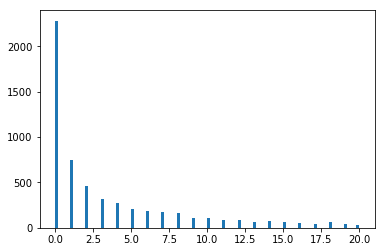

In [11]:
plt.hist(df_eurovoc_count["count"], bins = 100, range = [0, 20])

(array([2284.,    0.,    0.,    0.,    0.,  746.,    0.,    0.,    0.,
           0.,  466.,    0.,    0.,    0.,    0.,  315.,    0.,    0.,
           0.,    0.,  270.,    0.,    0.,    0.,    0.,  212.,    0.,
           0.,    0.,    0.,  183.,    0.,    0.,    0.,    0.,  179.,
           0.,    0.,    0.,    0.,  163.,    0.,    0.,    0.,    0.,
         112.,    0.,    0.,    0.,    0.,  111.,    0.,    0.,    0.,
           0.,   87.,    0.,    0.,    0.,    0.,   89.,    0.,    0.,
           0.,    0.,   59.,    0.,    0.,    0.,    0.,   79.,    0.,
           0.,    0.,    0.,   62.,    0.,    0.,    0.,    0.,   58.,
           0.,    0.,    0.,    0.,   47.,    0.,    0.,    0.,    0.,
          62.,    0.,    0.,    0.,    0.,   40.,    0.,    0.,    0.,
          37.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8

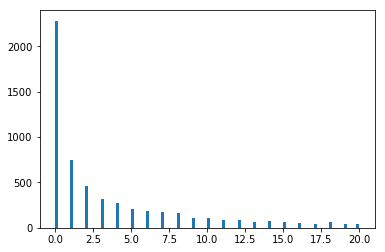

In [12]:
df_eurovoc_count.sort_values(by= "count", ascending = False, inplace = True)

In [13]:
df_eurovoc_count.to_excel("output/df_eurovoc_count.sorted.xlsx",
                          index = False
                         )

In [14]:
df_eurovoc_count

ID                                       ev   mID  \
6058        5451                          market approval  2031   
4342         889                                State aid  1606   
4546        3191                              import (EU)  2016   
6052        3173                    designation of origin  2031   
6081         893                                labelling  2031   
5103        5573                      product designation  2026   
1051        2771                      originating product  2021   
3155        3483                  international sanctions   806   
3151        5870                 revision of an agreement   806   
2265        1445                    veterinary inspection  5606   
3172        3870                       economic sanctions   806   
5411         616                  exchange of information  3231   
1090         192                           health control  2841   
1137        6569                              food safety  2841   
809         1474                           agreement (EU)  1016   
823         5618                   European Economic Area  1016   
6006        2735                                foodstuff  6026   
239         5283                          EU Member State  7231   
5718        5541                     control of State aid  4031   
294         1519                                    Italy  7231   
2259         191                     plant health control  5606   
253         1318                                  Germany  7231   
261         1085                                   France  7231   
6076        2081                       marketing standard  2031   
3568        5235                       technical standard  6411   
3289        5751                    Combined Nomenclature  2011   
2781        2300                            third country   811   
3288        4381                    common customs tariff  2011   
2861        1755                           animal disease  5631   
6262        2739                         chemical product  6811   
...          ...                                      ...   ...   
3754        5113  capacity to have rights and obligations  1211   
3769  c_471a61cf                         digital contract  1211   
3642        5981                  structural unemployment  4406   
3637        5980                    seasonal unemployment  4406   
3540        3848                         industrial robot  6411   
3634        1648                               redundancy  4406   
3544        4418                     materials technology  6411   
3545        1848                            mechanisation  6411   
3550        6299                      obsolete technology  6411   
3555        6300        prospective technological studies  6411   
3559        3744                             robotisation  6411   
3561        3698                       shape-memory alloy  6411   
1     c_433922a6                          cloud computing  3236   
3569        3640                    technological process  6411   
3571        3639                   traditional technology  6411   
3572        3696                      ultra-fine particle  6411   
3581        5940                  non-standard employment  4406   
3587        7209                     communication skills  4406   
3590        7191                      conduct of meetings  4406   
3592        5975                    cyclical unemployment  4406   
3593         731                    designated employment  4406   
3597        7212                           writing skills  4406   
3600        3519                        manpower planning  4406   
3604        4299                     employment structure  4406   
3619        3520                              job sharing  4406   
3620        5982                         temporary layoff  4406   
3624        7811                                mnemonics  4406   
3626        7210                       negotiation skills  44

In [26]:
df_eurovoc_count.query("mmev == 'ENVIRONMENT' and mev == 'environmental policy' and ev =='reduction of gas emissions'")["count"].sum()

244